In [1]:
import json
import pickle
import numpy as np
import logging
import os
import warnings
import joblib
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (accuracy_score, r2_score, mean_squared_error)
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.preprocessing import  StandardScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.model_selection import GridSearchCV, KFold
from yellowbrick.regressor import PredictionError, ResidualsPlot

logger = logging.getLogger()
if not logger.handlers:
    logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

In [2]:
data = pd.read_csv("D:/Repositorio/Proyecto Datos financieros de empresa/Data_processed/data_.csv")
data.head(5)

,segment,country,product,discount_band,date,month_name,units_sold,manufacturing_price,sale_price,gross_sales,discounts,sales,cogs,profit,month_number,year
0,2,0,1,3,2014-01-01,4,1618.5,3.0,20.0,32370.0,1597.880,32370.0,16185.0,16185.0,1.0,2014.0
1,2,2,1,3,2014-01-01,4,1321.0,3.0,20.0,26420.0,1308.340,26420.0,13210.0,13210.0,1.0,2014.0
2,3,1,1,3,2014-01-06,6,2178.0,3.0,15.0,32670.0,1119.660,32670.0,21780.0,10890.0,6.0,2014.0
3,3,2,1,3,2014-01-06,6,888.0,3.0,15.0,13320.0,644.072,13320.0,8880.0,4440.0,6.0,2014.0
4,3,3,1,3,2014-01-06,6,2470.0,3.0,15.0,37050.0,1913.460,37050.0,24700.0,12350.0,6.0,2014.0


In [ ]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Model training")

#mlflow ui --backend-store-uri sqlite:///mlflow.db

2024/11/20 15:36:37 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/11/20 15:36:37 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='file:///d:/Repositorio/Proyecto Datos financieros de empresa/mlruns/1', creation_time=1732131398293, experiment_id='1', last_update_time=1732131398293, lifecycle_stage='active', name='Model training', tags={}>

In [59]:
# Logger setup (if not already done)
import logging
logger = logging.getLogger()
if not logger.handlers:
    logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

def data_transform(df: pd.DataFrame):
    """
    This function transforms the data into X and y
    Args:
        df (pd.DataFrame): DataFrame containing the data
    Returns:
        X (pd.DataFrame): DataFrame with features
        y (pd.Series): Series with target variable
    """
    X = df.drop(["units_sold","date","year", "sales", "month_name"], axis=1)
    y = df["units_sold"]
    return X, y

def save_pickle(data, filename) -> None:
    """
    This function saves the data in a pickle file
    Args:
        data (object): data to save
        filename (str): filename
    Returns:
        None
    """
    directory = os.path.join("D:/Repositorio/Proyecto_Expextativa de vida", "data_procecced")
    os.makedirs(directory, exist_ok=True)  # Ensure the directory exists
    filepath = os.path.join(directory, f"{filename}.pkl")
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)

def split_train_test(X: np.array, y: pd.Series, test_size: float = 0.3, random_state: int = 42) -> tuple:
    """
    This function splits the data into train and test
    Args:
        X (np.array): array with the data
        y (pd.Series): series with the target
        test_size (float): test size
        random_state (int): random state
    Returns:
        X_train (np.array): array with the data for train
        X_test (np.array): array with the data for test
        y_train (pd.Series): series with the target for train
        y_test (pd.Series): series with the target for test
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    save_pickle((X_train, y_train), "train")
    save_pickle((X_test, y_test), "test")
    logger.info("Data saved successfully in pickle files")
    return X_train, X_test, y_train, y_test

def display_regression_report(model, name_model, developer, X_train, X_test, y_train, y_test, use_cv=False):
    """
    This function displays the regression report
    Args:
        model (object): model
        name_model (str): name of the model
        developer (str): developer name
        X_train (np.array): array with the data for train
        X_test (np.array): array with the data for test
        y_train (np.array): array with the target for train
        y_test (np.array): array with the target for test
        use_cv (bool): whether the model was obtained using cross-validation
    Returns:
        metric (list): list with the metrics
    """
    # Start experiment in MLflow
    with mlflow.start_run(run_name=name_model):
        mlflow.log_param("model", name_model)
        mlflow.log_param("developer", developer)
        # Empty list to store the metrics and then track them in MLflow
        metric = []

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_test_pred)
        # R2 Score
        r2 = r2_score(y_test, y_test_pred)
        metric.extend([mse, r2])
        
        mlflow.log_metric("Mean_squared_error", mse)
        mlflow.log_metric("R2_score", r2)
        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()
            mlflow.log_params(best_params)
        except AttributeError as e:
            logger.info(f"Error: {e}")

        mlflow.sklearn.log_model(model, f"model_{name_model}")
        
        print("MSE: ", mse)
        print("R2: ", r2)
    return 

def grid_search(model, folds, params, scoring):
    """
    This function performs a grid search
    Args:
        model (object): model
        folds (int): number of folds
        params (dict): dictionary with the parameters
        scoring (str): scoring
    Returns:
        grid_search (object): grid search
    """
    grid_search = GridSearchCV(model, cv=folds, param_grid=params, scoring=scoring, n_jobs=-1, verbose=1)
    return grid_search

def print_best_score_params(model):
    """
    This function prints the best score and best hyperparameters for baseline models
    Args:
        model (object): model
    Returns:
        None
    """
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

In [60]:
X,y = data_transform(data)
X_train, X_test, y_train, y_test = split_train_test(X, y)
print(data.shape)
print(X.shape)
print(y.shape)
print(f"X_train{X_train.shape},X_test{X_test.shape}")
print(F"Y_train{y_train.shape}----Y_test{y_test.shape}")

INFO  [root] Data saved successfully in pickle files


(700, 16)
(700, 11)
(700,)
X_train(490, 11),X_test(210, 11)
Y_train(490,)----Y_test(210,)


### Regresion Lineal

In [61]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)   
display_regression_report(model=lin_reg,
                            name_model= "LinearRegression",
                            developer= "Jose Luis",
                            X_train= X_train,
                            X_test=  X_test,
                            y_train= y_train,
                            y_test= y_test,
                            use_cv=False)

MSE:  361156.085241952
R2:  0.45143368486557356


### DesicioTreeRegressor

In [62]:
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train,y_train)
display_regression_report(model=dtr,
                              name_model= "DecisionTreeRegressor",
                              developer= "Jose Luis",
                              X_train= X_train,
                              y_train= y_train,
                              X_test= X_test,
                              y_test= y_test,
                              use_cv= False)

MSE:  10411.789285714285
R2:  0.984185350556688


### RandomForestRegressor

In [63]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train,y_train)
display_regression_report(model=rfr,
                              name_model="RandomForestRegressor",
                              developer= "Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= False)

MSE:  8525.767728333332
R2:  0.9870500617944993


### Supor Vector Machine

In [64]:
svr = SVR()
svr.fit(X_train,y_train)
display_regression_report(model=svr,
                              name_model="Supor Vector Machine",
                              developer= "JOse Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test)

MSE:  656423.2272488622
R2:  0.0029472417740998846


### XBBOOST

In [65]:
xgboost = XGBRegressor(random_state=42)
xgboost.fit(X_train,y_train)
display_regression_report(model=xgboost,
                              name_model="XGBoostRegressor",
                              developer="Jose Luis",
                              X_train=  X_train,
                              X_test=  X_test,
                              y_train= y_train,
                              y_test= y_test)

MSE:  8553.51381527155
R2:  0.987007917776184


### XGBRFRegressor

In [66]:
xgbRFoost = XGBRFRegressor(random_state=42)
xgbRFoost.fit(X_train,y_train)
display_regression_report(model=xgbRFoost,
                              name_model="XGBRFoostRegressor",
                              developer="Jose Luis",
                              X_train=  X_train,
                              X_test=  X_test,
                              y_train= y_train,
                              y_test= y_test)

MSE:  29919.334581951432
R2:  0.954554997704387


### GradientBostingRegressor

In [67]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train,y_train)
display_regression_report(model=gbr,
                              name_model="GradienteBostingRegressor",
                              developer="Jose Luis",
                              X_train=  X_train,
                              X_test=  X_test,
                              y_train= y_train,
                              y_test= y_test)

MSE:  13968.804298938165
R2:  0.978782538037622


In [68]:
gbr = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train,y_train)
display_regression_report(model=gbr,
                              name_model="GradienteBostingRegressor",
                              developer="Jose Luis",
                              X_train=  X_train,
                              X_test=  X_test,
                              y_train= y_train,
                              y_test= y_test)

MSE:  31175.43499598944
R2:  0.9526470847445208


### ExtraTreeRegressor

In [69]:
etr = ExtraTreesRegressor(random_state=42)
etr.fit(X_train,y_train)
display_regression_report(model=etr,
                              name_model="ExtraTreeRegressor",
                              developer="Jose Luis",
                              X_train=  X_train,
                              X_test=  X_test,
                              y_train= y_train,
                              y_test= y_test)

MSE:  4012.734908452383
R2:  0.9939049865354856


### Linear Regresion con GridSearchCV

In [72]:
folds = KFold(n_splits=5, shuffle=True, random_state=40)

In [73]:
lr = LinearRegression()
params_grid = {'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1, 1, 2],  # Usar todos los núcleos, 1 núcleo, 2 núcleos
    'positive': [True, False]
    
}
grid_search_lr = grid_search(lr, folds, params_grid, scoring= "neg_mean_squared_error")
grid_search_lr.fit(X_train, y_train)
print_best_score_params(grid_search_lr)
display_regression_report(model=grid_search_lr,
                              name_model="LinearRegressionCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Score:  -467815.13249907305
Best Hyperparameters:  {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}
MSE:  361156.085241952
R2:  0.45143368486557356


In [74]:
dtr = DecisionTreeRegressor()
params_grid = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2']  
    
}
grid_search_dtr = grid_search(dtr, folds, params_grid, scoring= "neg_mean_squared_error")
grid_search_dtr.fit(X_train, y_train)
print_best_score_params(grid_search_dtr)
display_regression_report(model=grid_search_dtr,
                              name_model="DecisionTreRegressorCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits
Best Score:  -30042.557908163268
Best Hyperparameters:  {'criterion': 'absolute_error', 'max_depth': 40, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
MSE:  27223.44880952381
R2:  0.9586498259092425


In [75]:
rfr = RandomForestRegressor()
params_grid = {'n_estimators': [100, 200, 300, 400, 500],  # Número de árboles en el bosque
    'max_features': ['auto', 'sqrt', 'log2'],   # Número de características a considerar en cada división
    'max_depth': [None, 10, 20, 30, 40, 50],    # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],            # Número mínimo de muestras necesarias para dividir un nodo
    'min_samples_leaf': [1, 2, 4],              # Número mínimo de muestras necesarias en una hoja   
}
grid_search_rfr = grid_search(rfr, folds, params_grid, scoring= "neg_mean_squared_error")
grid_search_rfr.fit(X_train, y_train)
print_best_score_params(grid_search_rfr)
display_regression_report(model=grid_search_rfr,
                              name_model="RandomForestRegressorCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


d:\Aplicaciones\Python\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1350 fits failed out of a total of 4050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1277 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Aplicaciones\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Aplicaciones\Python\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "d:\Aplicaciones\Python\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\Aplicaciones\Python\Lib\site-packages\skle

Best Score:  -82135.29978917018
Best Hyperparameters:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
MSE:  35678.95053520131
R2:  0.945806615968144


In [76]:
xgb = XGBRegressor()
params_grid = {'n_estimators': [50, 100, 300, 500],   # Número de árboles de decisión a construir
    'learning_rate': [0.01, 0.1, 0.3],    # Tasa de aprendizaje
    'max_depth': [3, 5, 8],                 # Profundidad máxima de un árbol
    'subsample': [0.6, 0.8, 1.0],          # Fracción de muestras para entrenar cada árbol
    'colsample_bytree': [0.6, 0.8, 1.0] 
}
grid_search_xgb = grid_search(xgb, folds, params_grid, scoring= "neg_mean_squared_error")
grid_search_xgb.fit(X_train, y_train)
print_best_score_params(grid_search_xgb)
display_regression_report(model=grid_search_xgb,
                              name_model="XGBosotCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Score:  -18067.44716812112
Best Hyperparameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.6}
MSE:  5485.626358650938
R2:  0.9916677858667301


In [77]:
xbgb = XGBRegressor()
params_grid = {'n_estimators': [100, 200, 400, 500],     # Número de árboles de decisión a construir
    'learning_rate': [0.05, 0.1, 0.2, 0.3],  # Tasa de aprendizaje
    'max_depth': [3, 5, 7],                  # Profundidad máxima de un árbol
    'subsample': [0.7, 0.9, 1.0],        # Fracción de muestras para entrenar cada árbol
    'colsample_bytree': [0.6, 0.8, 1.0]  # Fracción de características para cada árbol
}
grid_search_xbgb = grid_search(xbgb, folds, params_grid, scoring= "neg_mean_squared_error")
grid_search_xbgb.fit(X_train, y_train)
print_best_score_params(grid_search_xbgb)
display_regression_report(model=grid_search_xbgb,
                              name_model="XGBRosotCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Score:  -17246.080253604014
Best Hyperparameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
MSE:  8271.294580687147
R2:  0.9874365855237379


In [78]:
gbr = GradientBoostingRegressor()
params_grid = {'n_estimators': [100, 200, 400, 500],     # Número de árboles de decisión a construir
    'learning_rate': [ 0.05, 0.1, 0.2],  # Tasa de aprendizaje
    'max_depth': [3, 6, 7],                  # Profundidad máxima de un árbol
    'subsample': [0.6, 0.8, 1.0],        # Fracción de muestras para entrenar cada árbol
    'min_samples_split': [2, 5, 10]  
}
grid_search_gbr = grid_search(gbr, folds, params_grid, scoring= "neg_mean_squared_error")
grid_search_gbr.fit(X_train, y_train)
print_best_score_params(grid_search_gbr)
display_regression_report(model=grid_search_gbr,
                              name_model="GradientBostingRegressorCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Score:  -17936.912335173456
Best Hyperparameters:  {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_split': 10, 'n_estimators': 500, 'subsample': 1.0}
MSE:  5110.462026766125
R2:  0.9922376295534951


In [79]:
etr = ExtraTreesRegressor()
params_grid = {'n_estimators': [100, 200,400, 500],    # Número de árboles en el bosque
    'max_features': ['auto', 'sqrt', 'log2'],     # Número de características a considerar en cada división
    'max_depth': [None, 10, 20, 50],      # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],              # Número mínimo de muestras necesarias para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  
}
grid_search_etr = grid_search(etr, folds, params_grid, scoring= "neg_mean_squared_error")
grid_search_etr.fit(X_train, y_train)
print_best_score_params(grid_search_etr)
display_regression_report(model=grid_search_etr,
                              name_model="ExtraTreRegressorCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


d:\Aplicaciones\Python\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
223 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Aplicaciones\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Aplicaciones\Python\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "d:\Aplicaciones\Python\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\Aplicaciones\Python\Lib\site-packages\sklear

Best Score:  -64490.3226544898
Best Hyperparameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MSE:  32730.318331547624
R2:  0.9502853451623685


In [ ]:
feature_names = np.array(X.columns)  # Convertir a array de numpy

# Entrenar el modelo
model = ExtraTreesRegressor()
model.fit(X_train, y_train)

# Obtener importancias de las características
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

# Visualización del progreso
num_features = []
mses = []
selected_features_dict = {}  # Diccionario para almacenar las características seleccionadas

for i in range(1, len(importances) + 1):
    selected_indices = sorted_indices[:i]
    selected_columns = X.columns[selected_indices]  # Extraer nombres de las columnas seleccionadas

    X_train_selected = X_train[selected_columns]
    X_test_selected = X_test[selected_columns]

    model_selected = ExtraTreesRegressor()
    model_selected.fit(X_train_selected, y_train)
    y_pred = model_selected.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)

    num_features.append(i)
    mses.append(mse)
    selected_features_dict[i] = feature_names[selected_indices]  # Guardar los nombres de las características seleccionadas

plt.figure(figsize=(10, 6))
plt.plot(num_features, mses, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. Number of Features for Feature Selection')
plt.grid(True)
plt.show()

# Mostrar características seleccionadas para un número específico de características
num_selected = 8  # Cambia este valor para ver diferentes números de características seleccionadas
print(f"Características seleccionadas para {num_selected} características:")
print(selected_features_dict[num_selected])

### Evaluación de los modelos

In [80]:
etr = ExtraTreesRegressor(random_state=42)
etr.fit(X_train,y_train)
display_regression_report(model=etr,
                              name_model="ExtraTreeRegressor",
                              developer="Jose Luis",
                              X_train=  X_train,
                              X_test=  X_test,
                              y_train= y_train,
                              y_test= y_test)

MSE:  4012.734908452383
R2:  0.9939049865354856


In [83]:
colors = ['#c1121f','#669bbc', '#f4d35e', '#e9724c', '#ffc857']

In [88]:
#Function to plot feature importance provided the models.
def plot_feature_importance(df):   
    
    df = df.sort_values(by = '% Importance',
                                ascending = False).copy()
    
    df_temp = df['% Importance'].sort_values()
    
    display(df)
    
    fig, ax = plt.subplots(figsize=(10,6))

    bar = ax.barh(df_temp.index,
                 df_temp,
                 align = ('center'),
                 color =colors[0],
                 height = 0.9)

    ax.bar_label(bar, fmt = '%.f%%', padding=2)
    ax.set_xlabel('Importance (%)')
    ax.set_title('Feature Importance \n', fontsize=18)

,% Importance
cogs,29.467151
gross_sales,26.152641
sale_price,23.215315
profit,12.561615
segment,5.510760
discounts,1.970019
month_number,0.398291
discount_band,0.319367
country,0.256443
manufacturing_price,0.079788


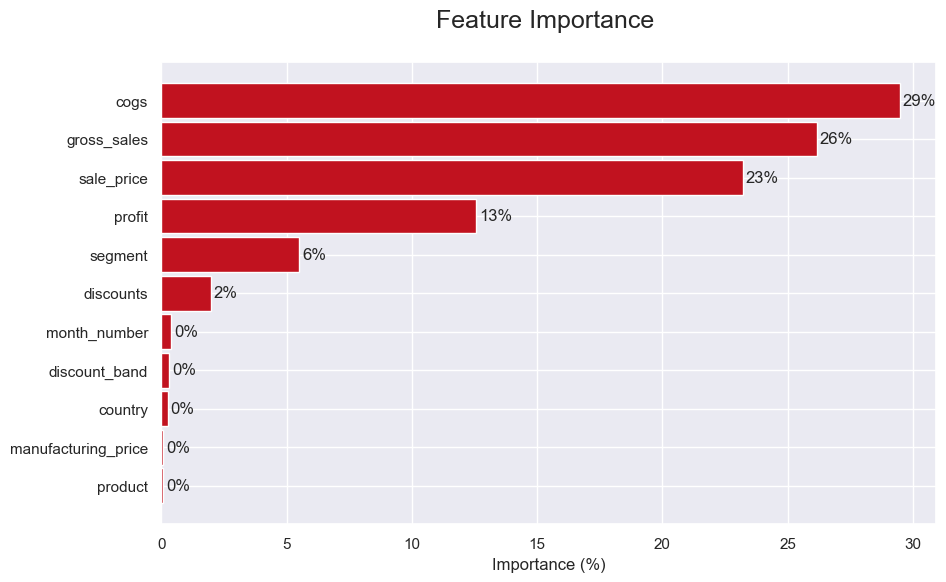

In [89]:
df_feature_importance = pd.DataFrame(data = 100* etr.feature_importances_, 
                                  index = X_train.columns,
                                  columns = ['% Importance'])

plot_feature_importance(df_feature_importance)

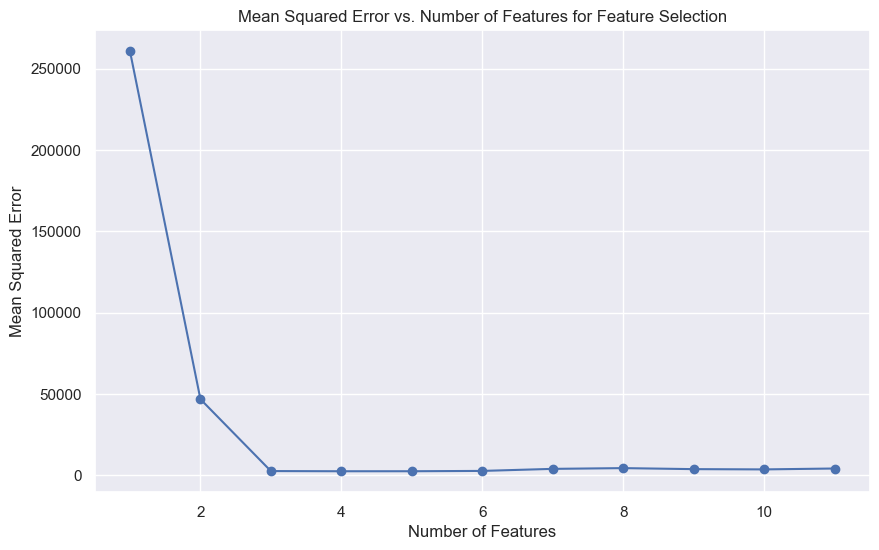

Características seleccionadas para 8 características:
['cogs' 'gross_sales' 'sale_price' 'profit' 'segment' 'discounts'
 'month_number' 'discount_band']


In [90]:
feature_names = np.array(X.columns)  # Convertir a array de numpy

# Entrenar el modelo
model = ExtraTreesRegressor(random_state=42)
model.fit(X_train, y_train)

# Obtener importancias de las características
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

# Visualización del progreso
num_features = []
mses = []
selected_features_dict = {}  # Diccionario para almacenar las características seleccionadas

for i in range(1, len(importances) + 1):
    selected_indices = sorted_indices[:i]
    selected_columns = X.columns[selected_indices]  # Extraer nombres de las columnas seleccionadas

    X_train_selected = X_train[selected_columns]
    X_test_selected = X_test[selected_columns]

    model_selected = ExtraTreesRegressor()
    model_selected.fit(X_train_selected, y_train)
    y_pred = model_selected.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)

    num_features.append(i)
    mses.append(mse)
    selected_features_dict[i] = feature_names[selected_indices]  # Guardar los nombres de las características seleccionadas

plt.figure(figsize=(10, 6))
plt.plot(num_features, mses, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. Number of Features for Feature Selection')
plt.grid(True)
plt.show()

# Mostrar características seleccionadas para un número específico de características
num_selected = 8  # Cambia este valor para ver diferentes números de características seleccionadas
print(f"Características seleccionadas para {num_selected} características:")
print(selected_features_dict[num_selected])

### ANALISIS DEL MODELO GANADOR

In [3]:
X = data[["cogs", "gross_sales","sale_price"]]
y = data["units_sold"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [5]:
etr = ExtraTreesRegressor(random_state=42)
etr.fit(X_train,y_train)
y_best_pred = etr.predict(X_test)
mse = mean_squared_error(y_test, y_best_pred)
r2 = r2_score(y_test, y_best_pred)
print(mse)
print(r2)

2531.724998928571
0.9961545184745662


In [6]:
# Guardar el modelo
import pickle
with open('modelo.pkl', 'wb') as f:
    pickle.dump(etr, f)


,% Importance
gross_sales,36.591059
cogs,36.086181
sale_price,27.322760


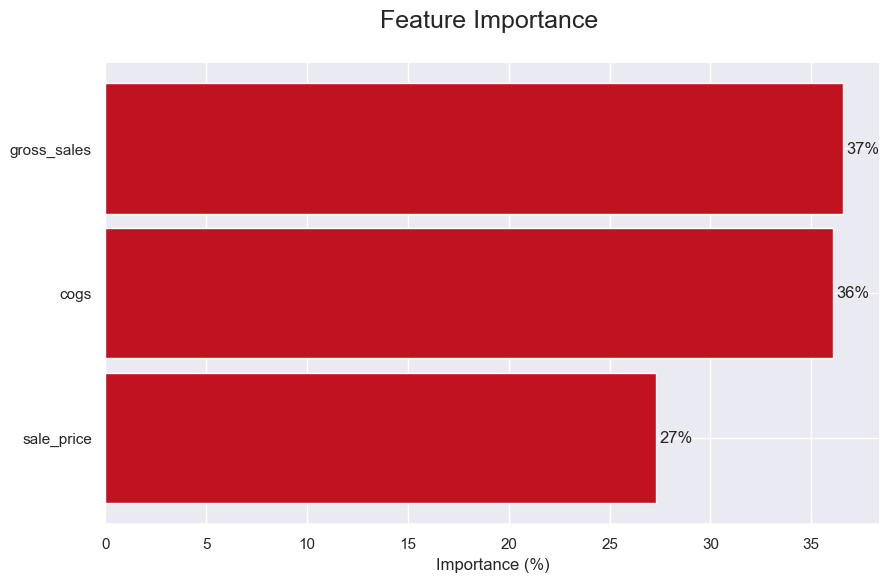

In [95]:
df_feature_importance = pd.DataFrame(data = 100* etr.feature_importances_, 
                                  index = X_train.columns,
                                  columns = ['% Importance'])

plot_feature_importance(df_feature_importance)

Text(0.5, 1.0, 'Predicted value and True value')

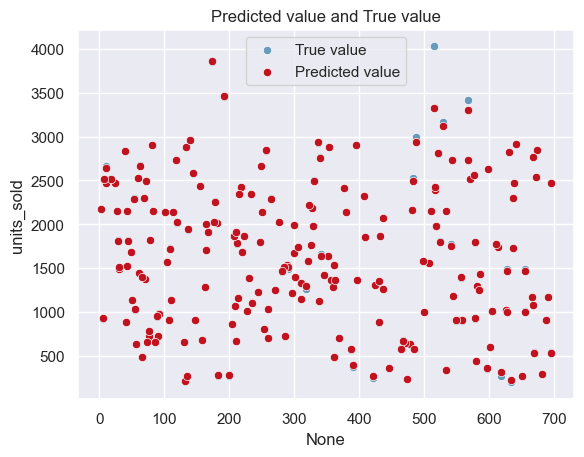

In [96]:
sns.scatterplot(x = X_test.index, y = y_test, color=colors[1], label = "True value")
sns.scatterplot(x = X_test.index, y = y_best_pred, color=colors[0], label = "Predicted value");

plt.title('Predicted value and True value')

d:\Aplicaciones\Python\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


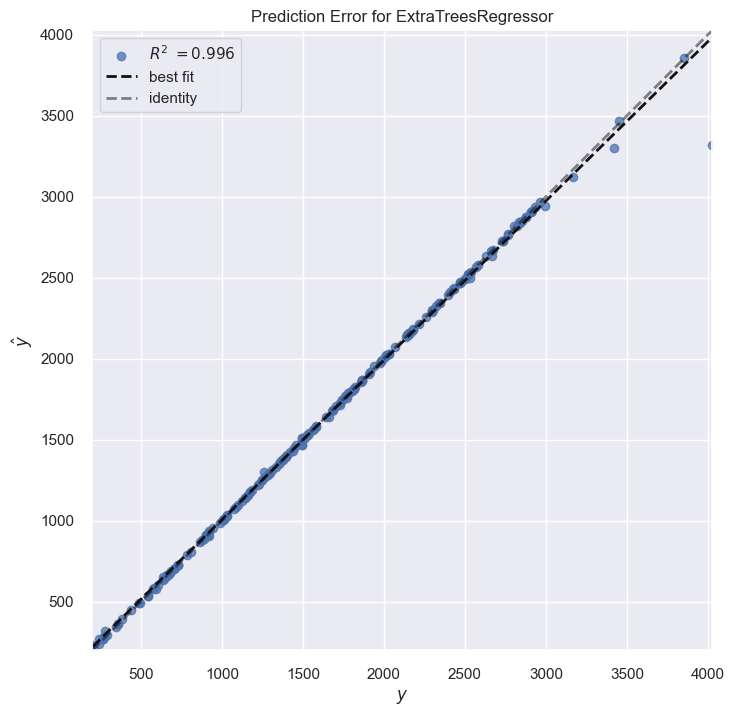

<Axes: title={'center': 'Prediction Error for ExtraTreesRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [101]:
#Plot prediction error
fig, ax = plt.subplots(figsize=(8,10))

pred_error = PredictionError(etr, scatter_kwargs={'color': 'red'})
pred_error.fit(X_train, y_train)
pred_error.score(X_test, y_test)
pred_error.show()

d:\Aplicaciones\Python\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


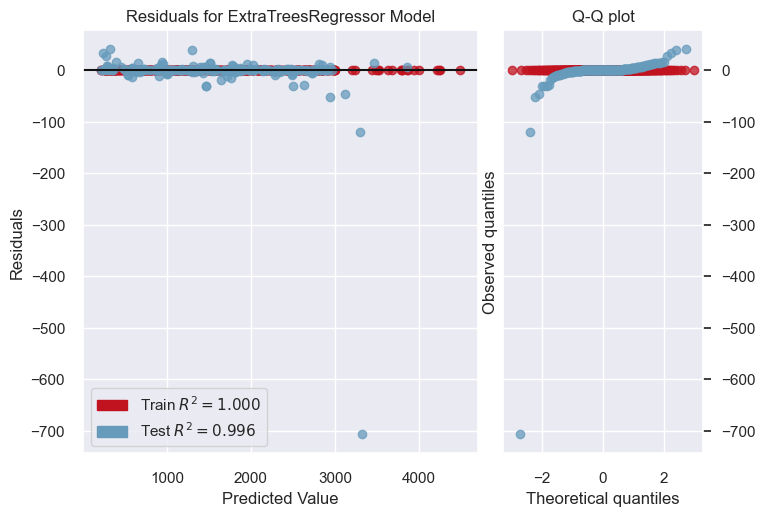

<Axes: title={'center': 'Residuals for ExtraTreesRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [102]:
visualizer = ResidualsPlot(etr,
                           train_color = colors[0],
                           test_color = colors[1],
                           hist = False, 
                           qqplot = True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

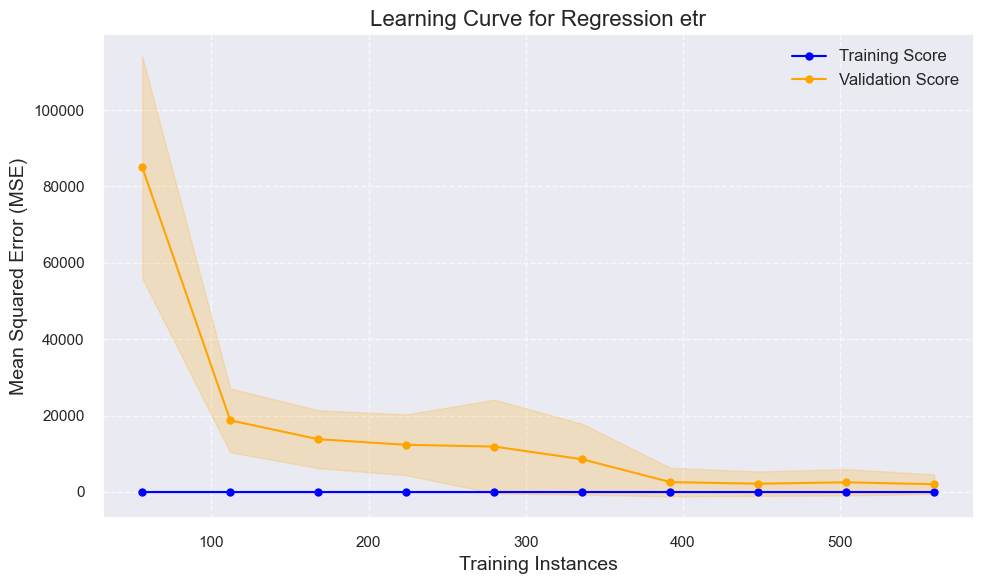

In [ ]:


from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
sns.set(style="darkgrid")
# Calcular la curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    etr, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Convertir las métricas a positivas
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))

# Curva de entrenamiento con sombra
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color='blue',
)

# Curva de validación con sombra
plt.plot(train_sizes, val_scores_mean, 'o-', color='orange', label='Validation Score')
plt.fill_between(
    train_sizes,
    val_scores_mean - val_scores_std,
    val_scores_mean + val_scores_std,
    alpha=0.2,
    color='orange',
)

# Personalización del gráfico
plt.title('Learning Curve for Regression etr', fontsize=16)
plt.xlabel('Training Instances', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()